# Аналитика интернет-магазина

Задача проекта: проанализировать результаты А/В теста.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import scipy.stats as stats

Файл orders.csv
* `transactionId` — идентификатор заказа;
* `visitorId` — идентификатор пользователя, совершившего заказ;
* `date` — дата, когда был совершён заказ;
* `revenue` — выручка заказа;
* `group` — группа A/B-теста, в которую попал заказ.   
   
Файл visitors.csv
* `date` — дата;
* `group` — группа A/B-теста;
* `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

In [2]:
visitors = pd.read_csv('visitors.csv')
orders = pd.read_csv('orders.csv')

In [3]:
display(orders.head())
orders.info()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [4]:
orders.columns = ['transaction_id', 'visitor_id', 'date', 'revenue', 'group']

In [5]:
print(f'Количество дубликатов в датасете: {orders.duplicated().sum()}')

Количество дубликатов в датасете: 0


Предобработка данных датасета `orders`: название столбцов приведены к snake case, дубликатов и пропусков нет, типы данных не меняем.

In [6]:
display(visitors.head())
visitors.info()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [7]:
print(f'Количество дубликатов в датасете: {visitors.duplicated().sum()}')

Количество дубликатов в датасете: 0


Предобработка данных датасета `visitors`: дубликатов и пропусков нет, типы данных не меняем.

#### Проведём дополнительный анализ данных наших датасетов.

In [8]:
print(f'количество групп в тесте: {visitors["group"].nunique()}')

количество групп в тесте: 2


In [9]:
print(f'Временной интервал А/В теста: {(pd.to_datetime(visitors["date"]).max() - pd.to_datetime(visitors["date"]).min()) + dt.timedelta(days=1)} ')

Временной интервал А/В теста: 31 days 00:00:00 


In [10]:
# проверим, за все ли дни временного интервала есть данные
print(f'Количество дней в датасете: {visitors["date"].nunique()}')

Количество дней в датасете: 31


In [11]:
print(f'А/В тест проводился с {pd.to_datetime(visitors["date"]).min().date()} по {pd.to_datetime(visitors["date"]).max().date()}')

А/В тест проводился с 2019-08-01 по 2019-08-31


In [12]:
print('количество пользователей в каждой группе:')
orders.groupby('group').agg({'visitor_id':'nunique'})

количество пользователей в каждой группе:


,visitor_id
group,
A,503
B,586


Количество пользователей существенно отличается, примерно на 16% в группе В больше, однако это некритично, так как метрики, по которым мы будем проводить анализ, не привязаны к количеству пользователей.

In [13]:
print('количество пользователей, которые попали в обе группы: ', end='')
print(orders.query('group == "A"')['visitor_id'].drop_duplicates()\
          .isin(orders.query('group == "B"')['visitor_id'].drop_duplicates()).sum())

количество пользователей, которые попали в обе группы: 58


Это чуть больше 5% от общего числа пользователей эксперимента. К сожалению, удаление этих пользователей не имеет смысла, так как они уже записаны в датасете `vistors`.

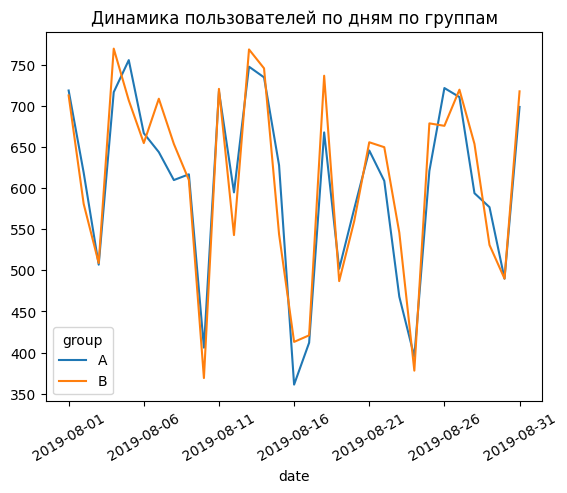

In [15]:
visitors.pivot_table(index='group', columns='date', values='visitors').T.plot(title='Динамика пользователей по дням по группам')
plt.xticks(rotation=30)

plt.show()

Пользователи равномерно распределялись по группам кроме 7 и 16 числа: в каждый из двух дней в группу А попало на 50 пользователей меньше.

### Построим график кумулятивной выручки по группам

In [16]:
# создаем массив уникальных пар значений дат и групп теста
dates_groups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
orders_aggregated = dates_groups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
                                    .agg({'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique', 'visitor_id' : 'nunique', 'revenue' : 'sum'}), axis=1)\
                                    .sort_values(by=['date','group'])
# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitors_aggregated = dates_groups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]\
                                    .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1)\
                                    .sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulative_data = orders_aggregated.merge(visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulative_data.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


In [17]:
# проверим корректность датафрейма cumulative_data
print(f'мин/макс даты: {pd.to_datetime(cumulative_data["date"]).min().date(), pd.to_datetime(cumulative_data["date"]).max().date()}')
print()
print(f'количество пользователей по группам:')
print(orders.groupby('group').agg({'visitor_id':'nunique'}))

мин/макс даты: (datetime.date(2019, 8, 1), datetime.date(2019, 8, 31))

количество пользователей по группам:
       visitor_id
group            
A             503
B             586


Данные совпадают, можем идти дальше.

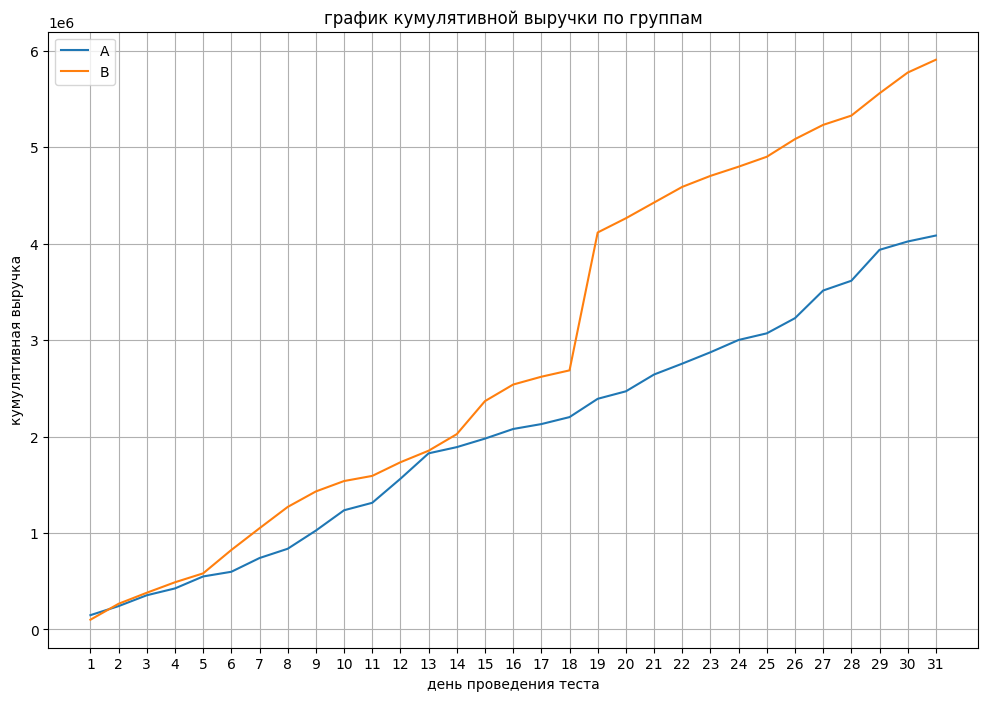

In [18]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulative_revenue_a = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulative_revenue_b = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(12, 8))
# Строим график выручки группы А
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='B')
plt.xticks(ticks=range(len(cumulative_revenue_a['date'])), labels=pd.DatetimeIndex(cumulative_revenue_a['date']).day)
plt.grid(visible=True)
plt.xlabel('день проведения теста')
plt.ylabel('кумулятивная выручка')
plt.title('график кумулятивной выручки по группам')

plt.legend();

**Выводы**: тенденция в обоих группах примерно одинаковая в течение всего периода, однако 19 числа выручка по группе B резко выросла. Причиной могут быть либо рост среднего чека (аномально крупные заказы), либо аномально большое число заказов.

### График кумулятивного среднего чека по группам

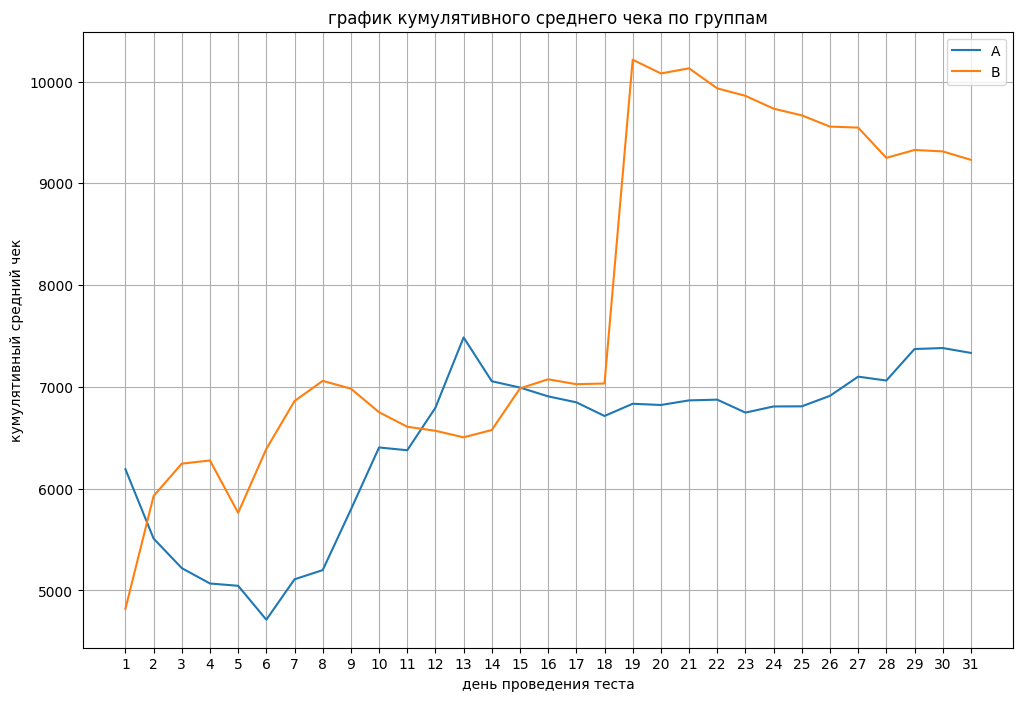

In [19]:
plt.figure(figsize=(12, 8))

plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue']/cumulative_revenue_a['orders'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue']/cumulative_revenue_b['orders'], label='B')
plt.xticks(ticks=range(len(cumulative_revenue_a['date'])), labels=pd.DatetimeIndex(cumulative_revenue_a['date']).day)

plt.grid(visible=True)
plt.xlabel('день проведения теста')
plt.ylabel('кумулятивный средний чек')
plt.title('график кумулятивного среднего чека по группам')

plt.legend();

**Выводы**: В 1, 12, 13 и 14 дни средний чек в группе А был больше, а в остальные дни наоборот. Средний чек группы В резко вырос с 7000 до 10000 19 числа, также как и выручка. После этого он стал падать. Этот график также подтверждает предоположение об аномалиях в этот день.

### График относительного изменения кумулятивного среднего чека группы B к группе A

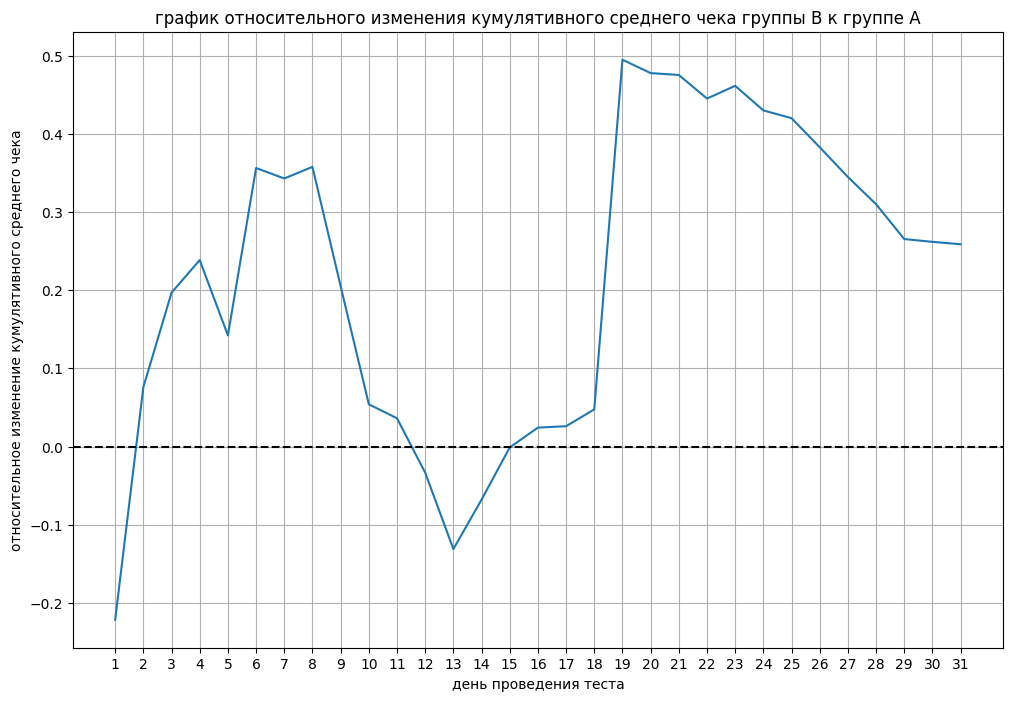

In [20]:
plt.figure(figsize=(12, 8))

# собираем данные в одном датафрейме
merged_сumulative_revenue = cumulative_revenue_a.merge(cumulative_revenue_b, left_on='date', right_on='date', how='left', suffixes=['_a', '_b'])

# cтроим отношение средних чеков
plt.plot(merged_сumulative_revenue['date'], (merged_сumulative_revenue['revenue_b']/merged_сumulative_revenue['orders_b'])/(merged_сumulative_revenue['revenue_a']/merged_сumulative_revenue['orders_a'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

plt.xticks(ticks=range(len(merged_сumulative_revenue['date'])), labels=pd.DatetimeIndex(merged_сumulative_revenue['date']).day)

plt.grid(visible=True)
plt.xlabel('день проведения теста')
plt.ylabel('относительное изменение кумулятивного среднего чека')
plt.title('график относительного изменения кумулятивного среднего чека группы B к группе A');

**Выводы**: график различия резко «скачет» на протяжении всего периода. Стоит отметить, что перед вероятными выбросами 19 числа показатель был близок к нулю.

### График кумулятивного среднего количества заказов на посетителя по группам

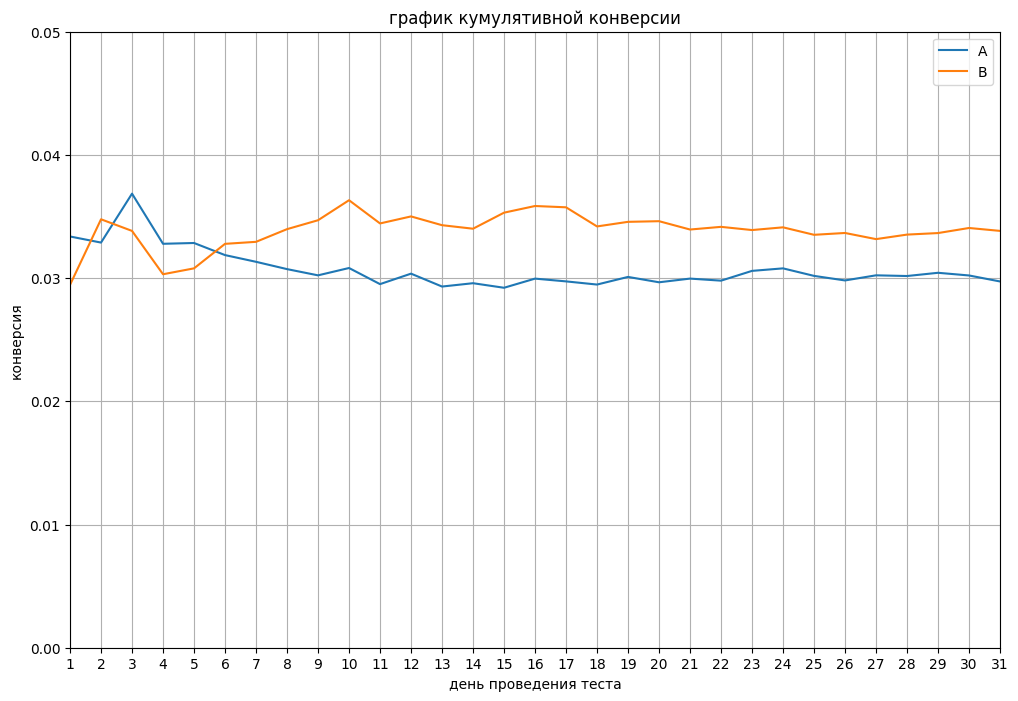

In [21]:
# считаем кумулятивную конверсию
cumulative_data['conversion'] = cumulative_data['orders']/cumulative_data['visitors']

# отделяем данные по группе A
cumulative_data_a = cumulative_data[cumulative_data['group']=='A']

# отделяем данные по группе B
cumulative_data_b = cumulative_data[cumulative_data['group']=='B']

# строим графики
plt.figure(figsize=(12, 8))
plt.plot(cumulative_data_a['date'], cumulative_data_a['conversion'], label='A')
plt.plot(cumulative_data_b['date'], cumulative_data_b['conversion'], label='B')
plt.legend()


plt.xticks(ticks=range(len(merged_сumulative_revenue['date'])), labels=pd.DatetimeIndex(cumulative_data_a['date']).day)
plt.grid(visible=True)
plt.xlabel('день проведения теста')
plt.ylabel('конверсия')
plt.title('график кумулятивной конверсии')
plt.axis(["2019-08-01", '2019-08-31', 0, 0.05]);

**Вывод:** Группы колебались примерно до 8 дня, но затем конверсия группы В вырвалась вперёд и зафиксировалась, а конверсия группы А просела и также зафиксировалась.

### График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

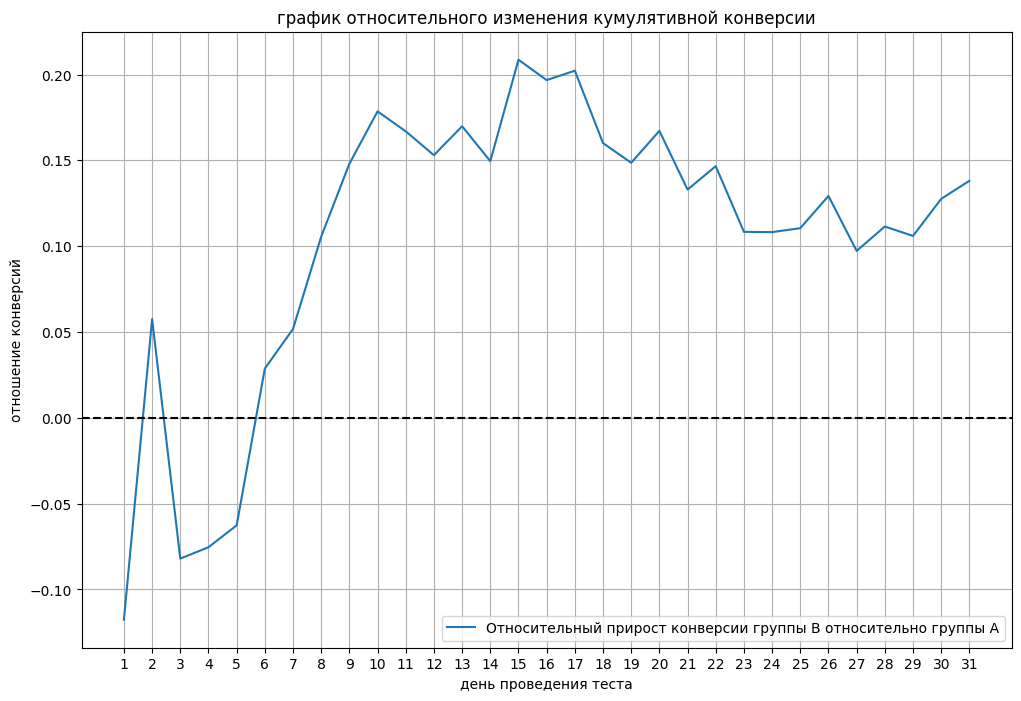

In [22]:
merged_cumulative_conversions = cumulative_data_a[['date','conversion']].\
                merge(cumulative_data_b[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['_a', '_b'])

plt.figure(figsize=(12, 8))

plt.plot(merged_cumulative_conversions['date'],\
         merged_cumulative_conversions['conversion_b']/merged_cumulative_conversions['conversion_a']-1, \
         label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

plt.xticks(ticks=range(len(merged_cumulative_conversions['date'])), labels=pd.DatetimeIndex(merged_сumulative_revenue['date']).day)
plt.grid(visible=True)
plt.xlabel('день проведения теста')
plt.ylabel('отношение конверсий')
plt.title('график относительного изменения кумулятивной конверсии')

plt.axhline(y=0, color='black', linestyle='--');

**Вывод:** В начале теста значения колебались, затем конверсия группы В вырвалась вперёд до конца проведения теста.

### Построим точечный график количества заказов по пользователям

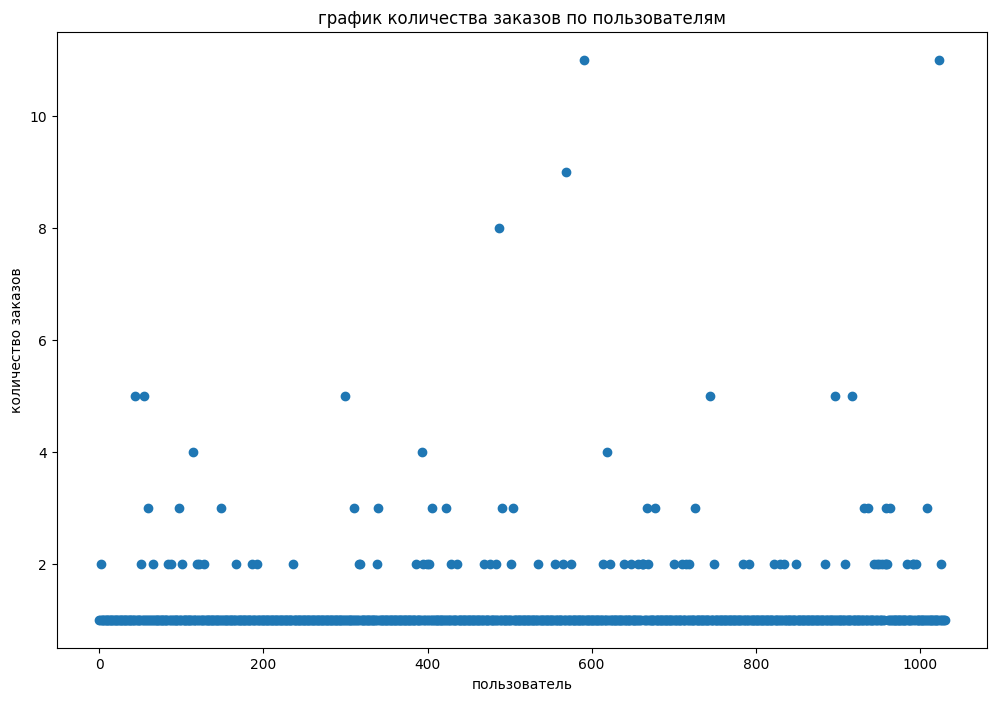

In [23]:
orders_by_users = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)

orders_by_users.columns = ['visitor_id', 'orders']

#print(orders_by_users.sort_values(by='orders', ascending=False).head(10))

x_values = pd.Series(range(0,len(orders_by_users)))

plt.figure(figsize=(12, 8))
plt.scatter(x_values, orders_by_users['orders'])
plt.xlabel('пользователь')
plt.ylabel('количество заказов')
plt.title('график количества заказов по пользователям');

**Выводы:** большинство покупателей заказывали только один раз. Однако доля пользователей с 2-3 заказами кажется значительной. Бóльшое количество заказов лишь у нескольких пользователей.

### Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Нужно выбрать границу для определения аномальных пользователей

In [24]:
print(np.percentile(orders_by_users['orders'], [90, 95, 99]))

[1. 2. 4.]


Не более 5% пользователей оформляли 2 и более заказа. И лишь 1% пользователей заказывали 4 и более раз. 

### Построим точечный график стоимостей заказов

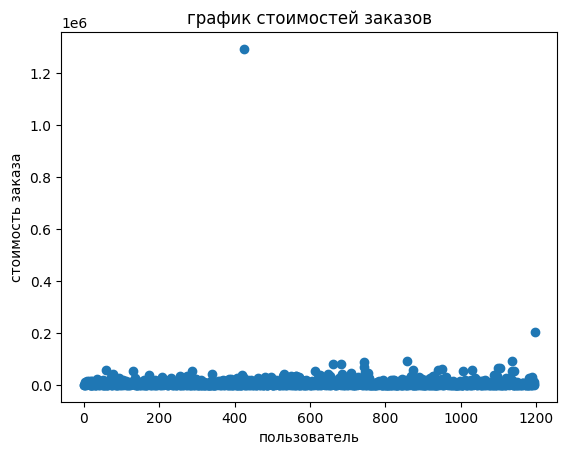

In [25]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])

plt.xlabel('пользователь')
plt.ylabel('стоимость заказа')
plt.title('график стоимостей заказов');

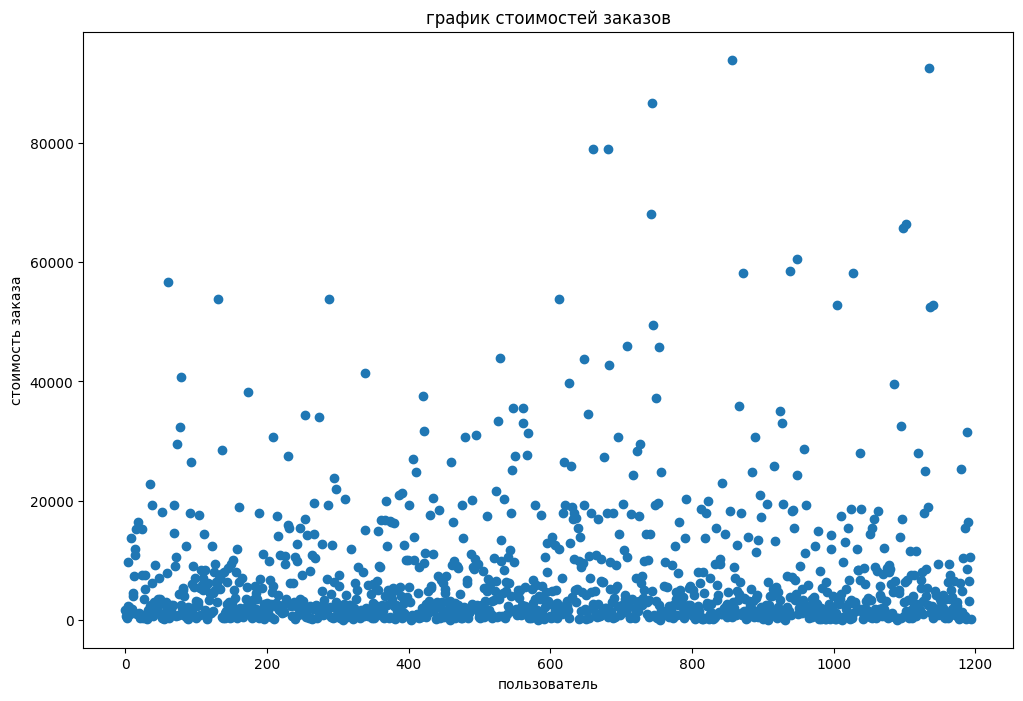

In [26]:
# построим график без двух выбросов
x_values = pd.Series(range(0,len(orders.query('revenue < 180000')['revenue'])))

plt.figure(figsize=(12, 8))
plt.scatter(x_values, orders.query('revenue < 180000')['revenue'])

plt.xlabel('пользователь')
plt.ylabel('стоимость заказа')
plt.title('график стоимостей заказов');

**Выводы:** В данных явно есть два аномально крупных заказа - на 200 тыс. и 1,3 млн руб. Стоимость основной доли заказов доходит до 20-30 тыс.

### Посчитаем 95-й и 99-й перцентили стоимости заказов. Выберем границу для определения аномальных заказов.

In [27]:
print(np.percentile(orders['revenue'], [90, 95, 99]))

[18168.  28000.  58233.2]


Выручка с 95% заказов меньше 28 тыс. И лишь с 1% заказов выручка превыщает 58233 руб. Примем за аномалии заказы дороже 95-ого перцентиля.

### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя и в среднем чеке заказа между группами по «сырым» данным

In [28]:
visitors_a_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_a_daily.columns = ['date', 'visitors_per_date_a']

visitors_a_cummulative = visitors_a_daily.apply(
        lambda x: visitors_a_daily[visitors_a_daily['date'] <= x['date']].agg(
            {'date': 'max', 'visitors_per_date_a': 'sum'}
        ),
        axis=1,
    )
visitors_a_cummulative.columns = ['date', 'visitors_cummulative_a']

visitors_b_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_b_daily.columns = ['date', 'visitors_per_date_b']

visitors_b_cummulative = visitors_b_daily.apply(
    lambda x: visitors_b_daily[visitors_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_b': 'sum'}
    ),
    axis=1,
)
visitors_b_cummulative.columns = ['date', 'visitors_cummulative_b']

orders_a_daily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_a_daily.columns = ['date', 'orders_per_date_a', 'revenue_per_date_a']

orders_a_cummulative = orders_a_daily.apply(
    lambda x: orders_a_daily[orders_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_a': 'sum', 'revenue_per_date_a': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

orders_a_cummulative.columns = ['date','orders_a_cummulative','revenue_cummulative_a']

orders_b_daily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_b_daily.columns = ['date', 'orders_per_date_b', 'revenue_per_date_b']

orders_b_cummulative = orders_b_daily.apply(
    lambda x: orders_b_daily[orders_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_b': 'sum', 'revenue_per_date_b': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_b_cummulative.columns = ['date', 'orders_cummulative_b', 'revenue_cummulative_b']

data = (
    orders_a_daily.merge(
        orders_b_daily, left_on='date', right_on='date', how='left'
    )
    .merge(orders_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(orders_b_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_a_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_b_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_b_cummulative, left_on='date', right_on='date', how='left')
)

data.head(5)

,date,orders_per_date_a,revenue_per_date_a,orders_per_date_b,revenue_per_date_b,orders_a_cummulative,revenue_cummulative_a,orders_cummulative_b,revenue_cummulative_b,visitors_per_date_a,visitors_per_date_b,visitors_cummulative_a,visitors_cummulative_b
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


In [29]:
orders_by_users_a = (
            orders[orders['group'] == 'A']
            .groupby('visitor_id', as_index=False)
            .agg({'transaction_id': pd.Series.nunique})
        )
orders_by_users_a.columns = ['visitor_id', 'orders']

orders_by_users_b = (
            orders[orders['group'] == 'B']
            .groupby('visitor_id', as_index=False)
            .agg({'transaction_id': pd.Series.nunique})
        )
orders_by_users_b.columns = ['visitor_id', 'orders']

In [30]:
sample_a = pd.concat(
            [orders_by_users_a['orders'],
            pd.Series(0, index=np.arange(data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])), name='orders')],
            axis=0
                    )

sample_b = pd.concat(
            [orders_by_users_b['orders'],
            pd.Series(0, index=np.arange(data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])), name='orders')],
            axis=0
                    )

Сформулируем нулевую и альтернативную гипотезы:   
Н0 - Средние значения числа заказов на посетителя в группах А и В равны.   
Н1 - Средние значения числа заказов на посетителя в группах А и В не равны.      
Уровень статистической значимости: 0.05

Выведем результат по критерию Манна-Уитни и относительный прирост среднего числа заказов группы B.

In [31]:
alpha = 0.05
result_mw = stats.mannwhitneyu(sample_a, sample_b)[1]

print("p-value равно: {0:.5f}".format(result_mw))

if result_mw < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

print()
print("Относительное различие в средних: {0:.5f}".format(sample_b.mean() / sample_a.mean() - 1))

p-value равно: 0.01679
Отвергаем нулевую гипотезу

Относительное различие в средних: 0.13808


А ещё найдём относительные различия в среднем чеке между группами. Сформулируем нулевую и альтернативную гипотезы:   
Н0 - Средние чеки заказа посетителей в группах А и В равны.   
Н1 - Средние чеки заказа посетителей в группах А и В не равны.   
Уровень статистической значимости: 0.05

In [32]:
alpha = 0.05
result_mw_2 = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]
print('p-value равно: {0:.5f}'.format(result_mw_2))

if result_mw_2 < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

print()
print('Относительное различие в средних: {0:.5f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

p-value равно: 0.72929
Не получилось отвергнуть нулевую гипотезу

Относительное различие в средних: 0.25871


**Выводы по "сырым" данным:**   
1) p-value по числу заказов показал статистическую значимость между группами, относительный прирост среднего числа заказа равен 13%.   
2) p-value по среднему чеку значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Впрочем, средний чек группы B больше среднего чека группы A на 25%.

### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя и в среднем чеке заказа между группами по «очищенным» данным 

Для этого нужно узнать, сколько было аномально крупных заказов.

Примем за аномальных пользователей тех, кто совершил **больше 2 заказов** или **совершил заказ дороже 28000 рублей**. Так мы уберём 5% пользователей с наибольшим числом заказов и 5% пользователей с дорогими заказами.

In [33]:
perc_revenue = np.percentile(orders['revenue'], 95)
perc_orders = np.percentile(orders_by_users['orders'], 95)

In [34]:
users_with_many_orders = pd.concat(
    [
        orders_by_users_a[orders_by_users_a['orders'] > perc_orders]['visitor_id'],
        orders_by_users_b[orders_by_users_b['orders'] > perc_orders]['visitor_id'],
    ],
    axis=0,
)
users_with_expensive_orders = orders[orders['revenue'] > perc_revenue]['visitor_id']
abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)
display(abnormal_users.head(5))
abnormal_users.shape[0] 

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
Name: visitor_id, dtype: int64

74

Отфильруем датасет, применим статистический критерий Манна-Уитни к полученным выборкам:

In [35]:
sample_a_filtered = pd.concat(
    [
        orders_by_users_a[
            np.logical_not(orders_by_users_a['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_b_filtered = pd.concat(
    [
        orders_by_users_b[
            np.logical_not(orders_by_users_b['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

Выведем результат по критерию Манна-Уитни и относительный прирост среднего числа заказов группы B. Нулевая и альтернативная гипотезы остаются те же.

In [36]:
alpha = 0.05
result_mw_3 = stats.mannwhitneyu(sample_a_filtered, sample_b_filtered)[1]

print("p-value равно: {0:.5f}".format(result_mw_3))

if result_mw_3 < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

print()
print("Относительное различие в средних: {0:.5f}".format(sample_b_filtered.mean() / sample_a_filtered.mean() - 1))

p-value равно: 0.01304
Отвергаем нулевую гипотезу

Относительное различие в средних: 0.17270


Найдём относительные различия в среднем чеке между группами:

In [37]:
alpha = 0.05
result_mw_4 = stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
        )[1]


print('{0:.3f}'.format(result_mw_4))

if result_mw_4 < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

print()
print("Относительное различие в средних: {0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        - 1
    )
)

0.738
Не получилось отвергнуть нулевую гипотезу

Относительное различие в средних: -0.020


**Выводы по "очищенным" данным:**   
1) p-value по числу заказов также показал статистическую значимость между группами, относительный прирост среднего числа заказа теперь равен 17%.   
2) p-value также значительно больше 0.05 и мы по-прежнему не можем отвергать нулевую гипотезу. В случае с "очищенными" данными средние чеки групп примерно равны.

## Вывод по результатам А/В теста.   
Принимаем решение остановить тест. Признаем его успешным.
Фиксируем результаты:
* Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;
* Статистически значимые различия обнаружены по среднему количеству заказов, в группе В этот показатель вырос;   
* Пользователь группы В стали делать больше заказов, однако средний чек не изменился;
* График относительного изменения кумулятивного среднего чека между группами показывает, что результат группы B чуть выше, однако такой результат достигнут, благодаря аномальному значению.

Мною и отделом маркетинга был проведён А/В тест двух групп посетителей магазина А и В.   
Параметры тестирования:
* Даты: 1 августа 2019 - 31 августа 2019;
* Количество посетителей: 1031, группа А - 503, В - 586, 58 посетителей попали в обе группы.   
   
**Финальный вывод:** 
* Анализ показал, что посетители группы В в среднем делают больше заказов. Относительный прирост равен 17%;
* При этом средний чек у обоих групп одинаковый, анализ не выявил различий между группами.
